In [39]:
%pip install --quiet dwave-ocean-sdk seaborn matplotlib 

Note: you may need to restart the kernel to use updated packages.


In [40]:
import numpy as np
import matplotlib.pyplot as plt
from dimod import BinaryQuadraticModel, SimulatedAnnealingSampler, BINARY
import seaborn as sns


In [41]:
# Define the problem parameters
num_evs = 5  # Number of EVs
time_slots = 10  # Number of time slots
grid_capacity = 20  # Maximum power that can be withdrawn from the grid at any time
power_requested = [30, 40, 50, 10, 50]  # Power requested by each EV
arrival_times = [1, 2, 3, 4, 5]  # Arrival times of each EV
departure_times = [5, 6, 9, 8, 10]  # Departure times of each EV

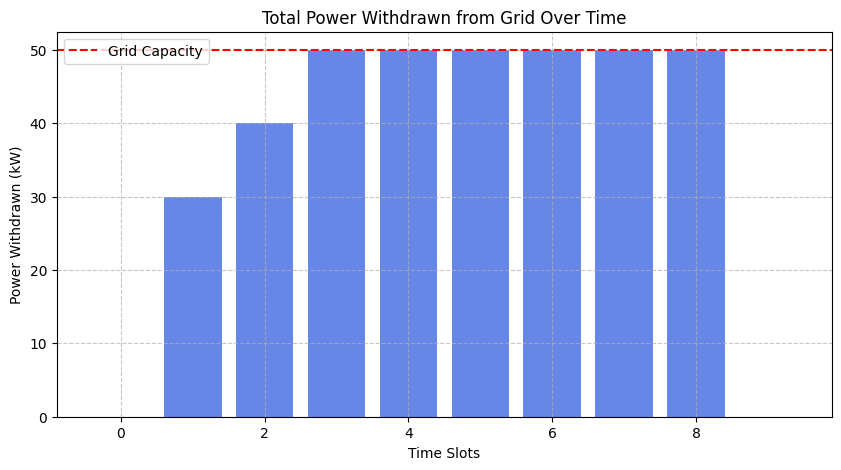

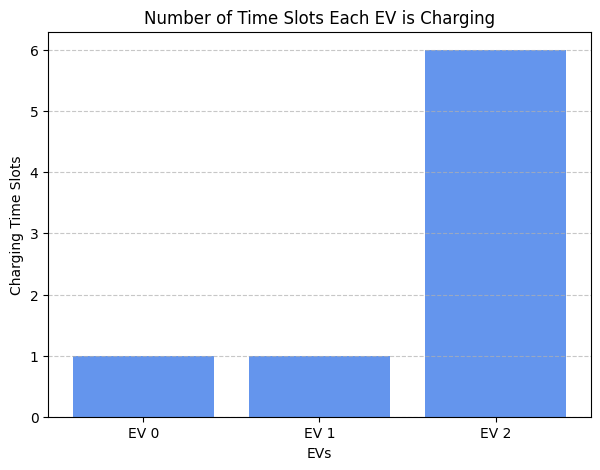

In [42]:

# Define problem parameters
num_evs = 3  # Number of EVs
time_slots = 10  # Number of time slots (each slot is 1 hour)
grid_capacity_kw = 50  # Maximum power withdrawable at any time (in kW)
power_requested_kwh = [30, 40, 50]  # Power requested by each EV (in kWh)
arrival_times = [1, 2, 3]  # Arrival times of each EV
departure_times = [5, 7, 9]  # Departure times of each EV

# Convert power requested from kWh to kW (assuming 1-hour time slots)
power_requested_kw = power_requested_kwh  # Since 1 kWh / 1 h = 1 kW

# Create a Binary Quadratic Model
bqm = BinaryQuadraticModel(BINARY)

# Objective function: Minimize total power withdrawn from the grid
for i in range(num_evs):
    for t in range(arrival_times[i], departure_times[i]):
        bqm.add_linear(f'x_{i}_{t}', power_requested_kw[i])

# Fast charging incentive: Prefer earlier charging
fast_charging_penalty = 1.0  # Small weight to encourage fast charging
for i in range(num_evs):
    for t in range(arrival_times[i], departure_times[i]):
        bqm.add_linear(f'x_{i}_{t}', -fast_charging_penalty)  # Negative penalty encourages early charging

# Constraint: Total power withdrawn should not exceed grid capacity
penalty_weight = 10.0  # Lagrange multiplier for constraint penalty
for t in range(time_slots):
    constraint_expr = []
    for i in range(num_evs):
        if arrival_times[i] <= t < departure_times[i]:
            constraint_expr.append((f'x_{i}_{t}', power_requested_kw[i]))

    if constraint_expr:  # Apply penalty only if there are charging EVs at time t
        bqm.add_linear_equality_constraint(
            [(var, coeff) for var, coeff in constraint_expr],
            lagrange_multiplier=penalty_weight,
            constant=-grid_capacity_kw
        )

# Solve the problem using simulated annealing
sampler = SimulatedAnnealingSampler()
response = sampler.sample(bqm, num_reads=100)

# Extract the best solution
best_solution = response.first.sample

# Create a charging schedule matrix (EVs x Time Slots)
charging_schedule = np.zeros((num_evs, time_slots))

# Populate schedule from the solution
for i in range(num_evs):
    for t in range(time_slots):
        if best_solution.get(f'x_{i}_{t}', 0) == 1:
            charging_schedule[i, t] = power_requested_kw[i]


# Calculate total power withdrawn from the grid at each time slot
total_power_withdrawn = np.sum(charging_schedule, axis=0)

# Plot 2: Total Power Withdrawn from Grid
plt.figure(figsize=(10, 5))
plt.bar(range(time_slots), total_power_withdrawn, color='royalblue', alpha=0.8)
plt.axhline(y=grid_capacity_kw, color='r', linestyle='--', label="Grid Capacity")
plt.xlabel("Time Slots")
plt.ylabel("Power Withdrawn (kW)")
plt.title("Total Power Withdrawn from Grid Over Time")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.7)
plt.show()

# Plot 3: Number of Time Slots Each EV is Charging
ev_charging_durations = np.sum(charging_schedule > 0, axis=1)

plt.figure(figsize=(7, 5))
plt.bar([f'EV {i}' for i in range(num_evs)], ev_charging_durations, color='cornflowerblue')
plt.xlabel("EVs")
plt.ylabel("Charging Time Slots")
plt.title("Number of Time Slots Each EV is Charging")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()
